In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import EmpiricalCovariance
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import seaborn as sns
from scipy import stats, signal
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 处理文件列不匹配问题

## 1.1 去除尾部多余字符

In [2]:
files = glob("../datas/NPI数据收集/LG-1/watchdata/*.csv")

In [12]:
def clean_csv(input_path, output_path=None, encoding='utf-8'):
    cleaned_lines = []
    # 读取并清理每一行
    with open(input_path, 'r', encoding=encoding) as f:
        for line in f:
            # 去除行尾换行符和多余逗号（包括连续逗号）
            cleaned_line = line.rstrip('\n')[:-2]
            cleaned_lines.append(cleaned_line)

    # 写入清理后的文件（可选）
    if output_path:
        with open(output_path, 'w', encoding='utf8') as f:
            f.write('\n'.join(cleaned_lines))

In [13]:
for file in files:
    clean_csv(file, output_path=os.path.join("../datas/NPI数据收集/LG-1/watchdata_new", os.path.basename(file)), encoding='gbk')

## 1.2 重新获取文件

In [26]:
# files = glob("../datas/NPI数据收集/LG-1/watchdata_new/*.csv")
# dfs = [pd.read_csv(file, encoding='utf8', on_bad_lines='skip') for file in files]
# df = pd.concat(dfs, ignore_index=True)
# df.to_csv("../datas/NPI数据收集/LG-1/watchdata.csv", index=False, encoding='utf8')
df = pd.read_csv("../datas/NPI数据收集/LG-1/watchdata.csv")
df.columns = [x.lower() for x in df.columns]

In [28]:
df_use = df[['time', '4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult', 's2s3installptid', 's2s3assystation', 's2s3assyplatformid', 'lock_platformid', 'lockscrewstation', 'lockscrewplatformid', 'maxpressspkdata', 'maxpresschgdata', 'bracketmaxpress', 'spk screw 4_half finaltorque', 'spk screw 4_half finalangle', 'spk screw 4 prevailingtorquemax', 'spk screw 4 prevailingtorquemaxangle', 'spk screw 4_half realangle', 'spk screw 4_half torqueat630', 'spk screw 4_half prev torque retest logic', 'kc screw 2_full finaltorque', 'kc screw 2_full finalangle', 'kc screw 2_full prevailingtorquemax', 'kc screw 2_full prevailingtorquemaxangle', 'kc screw 2_full realangle', 'kc screw 2_full torqueat630', 'kc screw 2_full prev torque retest logic', 'kc screw 1_full finaltorque', 'kc screw 1_full finalangle', 'kc screw 1_full prevailingtorquemax', 'kc screw 1_full prevailingtorquemaxangle', 'kc screw 1_full realangle', 'kc screw 1_full torqueat630', 'kc screw 1_full prev torque retest logic', 'spk screw 4_full finaltorque', 'spk screw 4_full finalangle', 'spk screw 4_full totalangle', 'spk screw 4_full prev torque retest logic']]

In [31]:
df_use[['4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult']].value_counts()

4_halfatlasresult  2_fullatlasresult  1_fullatlasresult  4_fullatlasresult
OK                 OK                 OK                 OK                   7640
                                      Toss               OK                     14
                   Toss               OK                 OK                     12
                   OK                 OK                 Toss                    2
                                      NG                 OK                      1
                                      OK                 NG                      1
                   Toss               Toss               OK                      1
Name: count, dtype: int64

In [33]:
# df_use.iloc[:60].to_csv("../datas/NPI数据收集/LG-1/temp.csv", index=False)
df_use.describe()

,s2s3assystation,s2s3assyplatformid,lockscrewstation,lockscrewplatformid,maxpressspkdata,maxpresschgdata,bracketmaxpress,spk screw 4_half finaltorque,spk screw 4_half finalangle,spk screw 4 prevailingtorquemax,...,kc screw 1_full finalangle,kc screw 1_full prevailingtorquemax,kc screw 1_full prevailingtorquemaxangle,kc screw 1_full realangle,kc screw 1_full torqueat630,kc screw 1_full prev torque retest logic,spk screw 4_full finaltorque,spk screw 4_full finalangle,spk screw 4_full totalangle,spk screw 4_full prev torque retest logic
count,7847.000000,7847.000000,7861.0,7861.000000,7562.000000,7562.000000,7554.000000,7671.000000,7671.000000,7671.000000,...,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000
mean,2.011469,1.009685,4.0,1.012339,19.631248,7.846818,11.493580,0.171872,907.780336,0.076923,...,863.683223,0.098077,506.974118,1136.806437,0.091078,0.002477,0.343578,67.775104,975.555440,0.000130
std,0.106486,0.097942,0.0,0.110402,0.127820,0.211144,0.815064,0.000202,157.948214,0.043681,...,142.160454,0.076047,214.653849,142.062713,0.078332,0.049710,0.001365,71.436031,134.759202,0.011418
min,2.000000,1.000000,4.0,1.000000,18.470000,7.000000,0.080000,0.171600,-167.400000,0.019550,...,-89.640000,0.016800,-245.160000,181.440000,0.007700,0.000000,0.226650,14.580000,10.260000,0.000000
25%,2.000000,1.000000,4.0,1.000000,19.540000,7.830000,11.160000,0.171700,810.540000,0.045150,...,757.080000,0.048700,495.180000,1030.320000,0.040825,0.000000,0.343350,43.200000,880.740000,0.000000
50%,2.000000,1.000000,4.0,1.000000,19.620000,7.890000,11.700000,0.171850,914.760000,0.065850,...,861.840000,0.072350,603.720000,1135.080000,0.063250,0.000000,0.343550,51.300000,974.160000,0.000000
75%,2.000000,1.000000,4.0,1.000000,19.720000,7.940000,12.040000,0.172000,1015.740000,0.095100,...,963.900000,0.115450,628.020000,1237.140000,0.108725,0.000000,0.343750,63.720000,1070.820000,0.000000
max,3.000000,2.000000,4.0,2.000000,20.170000,9.940000,17.170000,0.172900,1292.220000,0.344150,...,1320.840000,0.344750,629.640000,1593.540000,0.344750,1.000000,0.344850,2024.460000,2356.560000,1.000000


# 2. 异常监测

## 2.1 方案一

In [ ]:
class ScrewDriverMonitor:
    def __init__(self, df):
        self.df = df
        self.batch_state = {}
        self.thresholds = {
            'torque_variance': 0.1,
            'angle_variance': 0.05,
            'success_rate': 0.95,
            'wear_score': 0.7
        }
    
    def preprocess_data(self):
        """数据预处理"""
        # 筛选有效数据
        valid_columns = [
            'time', '4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', 
            '4_fullatlasresult', 's2s3installptid', 'maxpressspkdata', 
            'spk screw 4_half finaltorque', 'spk screw 4_half finalangle',
            'kc screw 1_full finaltorque', 'kc screw 1_full finalangle',
            'kc screw 2_full finaltorque', 'kc screw 2_full finalangle',
            'spk screw 4_full finaltorque', 'spk screw 4_full finalangle'
        ]
        
        self.df = self.df[valid_columns]
        self.df['time'] = pd.to_datetime(self.df['time'])
        
        # 去除无效记录
        self.df = self.df.dropna(subset=['s2s3installptid'])
        
        return self.df
    
    def extract_features(self, group):
        """提取特征参数"""
        features = {}
        
        # 扭矩相关特征
        torque_cols = ['spk screw 4_half finaltorque', 'kc screw 2_full finaltorque', 'kc screw 1_full finaltorque', 'spk screw 4_full finaltorque']
        
        torques = group[torque_cols].values.flatten()
        features['mean_torque'] = np.nanmean(torques)
        features['std_torque'] = np.nanstd(torques)
        features['torque_cv'] = features['std_torque'] / features['mean_torque'] if features['mean_torque'] != 0 else 0
        
        # 角度相关特征
        angle_cols = ['spk screw 4_half finalangle', 'kc screw 2_full finalangle', 'kc screw 1_full finalangle', 'spk screw 4_full finalangle']
        
        angles = group[angle_cols].values.flatten()
        features['mean_angle'] = np.nanmean(angles)
        features['std_angle'] = np.nanstd(angles)
        features['angle_cv'] = features['std_angle'] / features['mean_angle'] if features['mean_angle'] != 0 else 0
        
        # 成功率
        result_cols = ['4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult']
        success_count = sum(group[result_cols].values.flatten() == 'OK')
        features['success_rate'] = success_count / len(result_cols)
        
        return features
    
    def calculate_wear_score(self, features):
        """计算磨损评分"""
        score = 0
        
        # 扭矩变异度
        torque_score = min(features['torque_cv'] / self.thresholds['torque_variance'], 1)
        score += torque_score * 0.4
        
        # 角度变异度
        angle_score = min(features['angle_cv'] / self.thresholds['angle_variance'], 1)
        score += angle_score * 0.3
        
        # 成功率
        success_score = 1 - min((1 - features['success_rate']) / (1 - self.thresholds['success_rate']), 1)
        score += success_score * 0.3
        
        return score
    
    def assess_batch_state(self, platform_id, features):
        """评估批杆状态"""
        if platform_id not in self.batch_state:
            self.batch_state[platform_id] = {
                'history': [],
                'current_score': 0,
                'trend': 'stable'
            }
        
        wear_score = self.calculate_wear_score(features)
        self.batch_state[platform_id]['history'].append(wear_score)
        self.batch_state[platform_id]['current_score'] = wear_score
        
        # 评估趋势
        history = self.batch_state[platform_id]['history']
        if len(history) > 3:
            trend = np.polyfit(range(len(history)), history, 1)[0]
            self.batch_state[platform_id]['trend'] = 'worsening' if trend > 0 else 'improving'
        else:
            self.batch_state[platform_id]['trend'] = 'stable'
        
        return wear_score
    
    def generate_alert(self, platform_id):
        """生成预警信息"""
        state = self.batch_state[platform_id]
        alert_level = 'none'
        alert_msg = ''
        
        if state['current_score'] > self.thresholds['wear_score']:
            alert_level = 'critical'
            alert_msg = '批杆磨损严重，建议立即更换'
        elif state['current_score'] > 0.5:
            alert_level = 'warning'
            alert_msg = '批杆磨损加剧，建议尽快检查'
        elif state['trend'] == 'worsening':
            alert_level = 'notice'
            alert_msg = '批杆磨损趋势恶化，建议关注'
        
        return {
            'platform_id': platform_id,
            'alert_level': alert_level,
            'current_score': state['current_score'],
            'trend': state['trend'],
            'message': alert_msg
        }
    
    def monitor(self):
        """主监控函数"""
        # 分组处理
        for platform_id, group in self.df.groupby('s2s3installptid'):
            features = self.extract_features(group)
            wear_score = self.assess_batch_state(platform_id, features)
            alert = self.generate_alert(platform_id)
            
            # 输出预警信息
            print(f"平台 {platform_id} 监控结果：")
            print(f"磨损评分：{wear_score:.3f}")
            print(f"状态趋势：{alert['trend']}")
            print(f"预警等级：{alert['alert_level']}")
            print(f"建议：{alert['message']}")
            print("-" * 50)
    
    def plot_trend(self, platform_id):
        """绘制状态趋势图"""
        state = self.batch_state[platform_id]
        if platform_id in self.batch_state:
            plt.figure(figsize=(10, 4))
            plt.plot(state['history'], marker='o', label='磨损评分')
            plt.axhline(y=self.thresholds['wear_score'], color='r', linestyle='--', label='更换阈值')
            plt.title(f'平台 {platform_id} 批杆磨损趋势')
            plt.xlabel('检测次数')
            plt.ylabel('磨损评分')
            plt.legend()
            plt.show()

平台 1.0 监控结果：
磨损评分：45763.000
状态趋势：stable
预警等级：critical
建议：批杆磨损严重，建议立即更换
--------------------------------------------------
平台 2.0 监控结果：
磨损评分：85.000
状态趋势：stable
预警等级：critical
建议：批杆磨损严重，建议立即更换
--------------------------------------------------


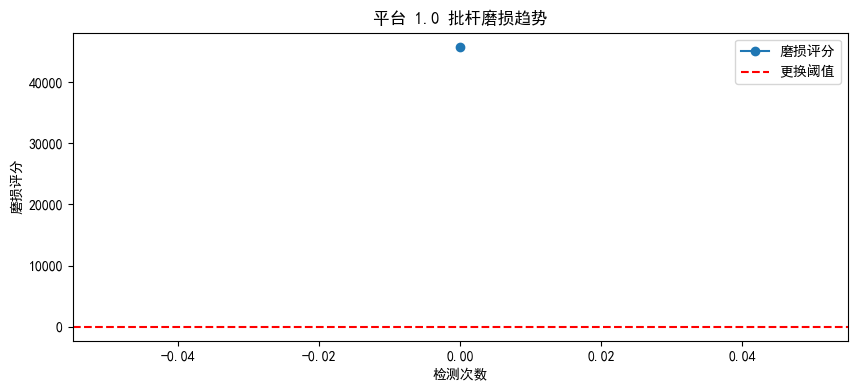

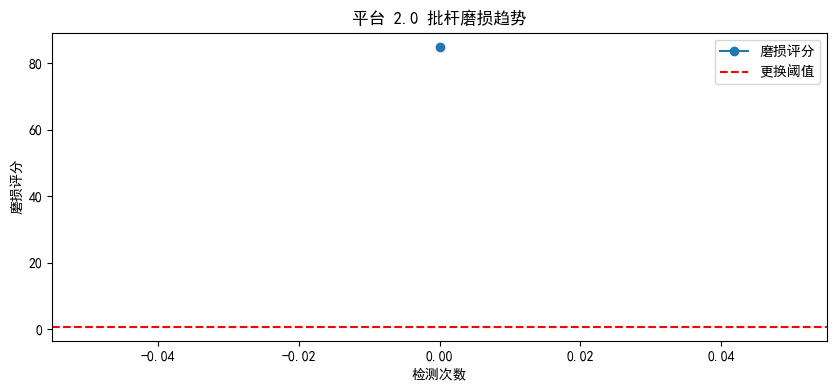

In [40]:
# 创建监控器
monitor = ScrewDriverMonitor(df_use)
# 运行监控
monitor.monitor()

# 绘制趋势图
for platform_id in monitor.batch_state.keys():
    monitor.plot_trend(platform_id)

## 2.2 方案二

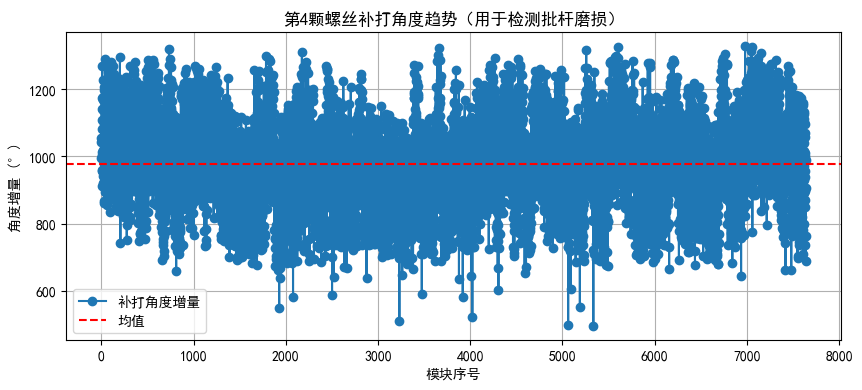

      torque_4full  angle_4full_increment  angle_inc_z  torque_4full_z  \
7630       0.34375                1011.42     0.139479        1.099982   
7631       0.34330                 849.96    -1.030715       -0.772610   
7632       0.34340                1002.78     0.529134       -0.351187   
7633       0.34395                1097.28     0.912975        1.139601   
7634       0.34355                 868.86    -1.052315       -0.292078   
7635       0.34340                 955.26    -0.160752       -0.817818   
7636       0.34325                 762.48    -1.032700       -0.993377   
7637       0.34330                 689.04    -0.823443       -0.215398   
7638       0.34350                 988.74     1.122344        1.125386   
7639       0.34330                 906.66     0.291721       -0.572393   

      health_score recommendation  
7630      0.928422           🟢 正常  
7631      0.912415           🟢 正常  
7632      0.957763           🟢 正常  
7633      0.895105           🟡 预警  
7634 

In [42]:
# -------------------------------
# 1. 数据加载与清洗
# -------------------------------
# 数据清洗
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 过滤OK结果
ok_mask = (df['4_halfatlasresult'] == 'OK') & \
          (df['2_fullatlasresult'] == 'OK') & \
          (df['1_fullatlasresult'] == 'OK') & \
          (df['4_fullatlasresult'] == 'OK')
df_use = df[ok_mask].copy()

# -------------------------------
# 2. 特征工程
# -------------------------------
def extract_features(row):
    features = {
        'torque_4half': row['spk screw 4_half finaltorque'],
        'angle_4half_total': row['spk screw 4_half realangle'],
        
        'torque_2full': row['kc screw 2_full finaltorque'],
        'angle_2full_total': row['kc screw 2_full realangle'],
        'prev_torque_2full': row['kc screw 2_full prevailingtorquemax'],
        
        'torque_1full': row['kc screw 1_full finaltorque'],
        'angle_1full_total': row['kc screw 1_full realangle'],
        
        'torque_4full': row['spk screw 4_full finaltorque'],
        'angle_4full_total': row['spk screw 4_full finalangle'],
        'angle_4full_increment': row['spk screw 4_full totalangle'],  # 关键：补打角度
        
        'maxpress_spk': row['maxpressspkdata'],
        'bracket_maxpress': row['bracketmaxpress'],
        
        'platform_id': row['s2s3assyplatformid'],
        'install_ptid': row['s2s3installptid'],
    }
    return pd.Series(features)

df_features = df_use.apply(extract_features, axis=1)

# 处理异常值（如负的 prev_torque）
df_features = df_features[df_features['prev_torque_2full'] > 0]

# -------------------------------
# 3. 滑动窗口趋势分析（核心预警逻辑）
# -------------------------------
window_size = 3  # 小窗口便于演示，实际建议50~100
df_features = df_features.reset_index(drop=True)

# 计算滑动平均和Z-score
df_features['angle_inc_mean'] = df_features['angle_4full_increment'].rolling(window=window_size, min_periods=1).mean()
df_features['angle_inc_std'] = df_features['angle_4full_increment'].rolling(window=window_size, min_periods=1).std()
df_features['angle_inc_z'] = (df_features['angle_4full_increment'] - df_features['angle_inc_mean']) / (df_features['angle_inc_std'] + 1e-6)

df_features['torque_4full_mean'] = df_features['torque_4full'].rolling(window=window_size, min_periods=1).mean()
df_features['torque_4full_std'] = df_features['torque_4full'].rolling(window=window_size, min_periods=1).std()
df_features['torque_4full_z'] = (df_features['torque_4full'] - df_features['torque_4full_mean']) / (df_features['torque_4full_std'] + 1e-6)

# 健康评分（简化版）
df_features['health_score'] = (
    0.6 * (1 - np.abs(df_features['torque_4full_z']) * 0.1).clip(0, 1) +
    0.4 * (1 - np.abs(df_features['angle_inc_z']) * 0.1).clip(0, 1)
)

# -------------------------------
# 4. 预警判断
# -------------------------------
def judge_wear(row):
    if row['health_score'] < 0.7:
        return '🔴 更换'
    elif row['health_score'] < 0.9:
        return '🟡 预警'
    else:
        return '🟢 正常'

df_features['recommendation'] = df_features.apply(judge_wear, axis=1)

# -------------------------------
# 5. 可视化（角度增量趋势）
# -------------------------------
plt.figure(figsize=(10, 4))
plt.plot(df_features.index, df_features['angle_4full_increment'], label='补打角度增量', marker='o')
plt.axhline(y=df_features['angle_4full_increment'].mean(), color='r', linestyle='--', label='均值')
plt.title('第4颗螺丝补打角度趋势（用于检测批杆磨损）')
plt.xlabel('模块序号')
plt.ylabel('角度增量 (°)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 6. 输出结果
# -------------------------------
print(df_features[[
    'torque_4full', 'angle_4full_increment', 
    'angle_inc_z', 'torque_4full_z', 
    'health_score', 'recommendation'
]].tail(10))

In [43]:
df_features

,torque_4half,angle_4half_total,torque_2full,angle_2full_total,prev_torque_2full,torque_1full,angle_1full_total,torque_4full,angle_4full_total,angle_4full_increment,...,platform_id,install_ptid,angle_inc_mean,angle_inc_std,angle_inc_z,torque_4full_mean,torque_4full_std,torque_4full_z,health_score,recommendation
0,0.17185,1231.74,0.34345,1369.44,0.08725,0.34370,1415.88,0.34430,37.26,996.30,...,1.0,S2-1,996.30,NaN,NaN,0.344300,NaN,NaN,NaN,🟢 正常
1,0.17200,1288.98,0.34370,1485.00,0.04190,0.34360,1423.98,0.34325,26.46,1042.74,...,1.0,S2-1,1019.52,32.838039,0.707107,0.343775,0.000742,-0.706156,0.929346,🟢 正常
2,0.17240,1299.78,0.34335,1530.90,0.04325,0.34355,1410.48,0.34345,28.62,1055.70,...,1.0,S3-1,1031.58,31.232983,0.772261,0.343667,0.000558,-0.387927,0.945834,🟢 正常
3,0.17185,1252.26,0.34350,1273.32,0.02810,0.34360,1218.24,0.34335,27.00,1005.48,...,1.0,S3-1,1034.64,26.071433,-1.118466,0.343350,0.000100,0.000000,0.955261,🟢 正常
4,0.17180,1389.96,0.34360,1512.54,0.03185,0.34420,1346.76,0.34385,57.78,1174.50,...,1.0,S2-1,1078.56,86.797896,1.105326,0.343550,0.000265,1.129624,0.888010,🟡 预警
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,0.17165,1165.86,0.34340,1065.42,0.09275,0.34370,1139.40,0.34340,62.10,955.26,...,1.0,S2-1,973.80,115.333095,-0.160752,0.343633,0.000284,-0.817818,0.944501,🟢 正常
7636,0.17205,994.68,0.34340,1093.50,0.06850,0.34395,886.14,0.34325,41.04,762.48,...,1.0,S2-1,862.20,96.562409,-1.032700,0.343400,0.000150,-0.993377,0.899089,🟡 预警
7637,0.17225,908.28,0.34360,998.46,0.11730,0.34360,869.94,0.34330,54.00,689.04,...,1.0,S2-1,802.26,137.495849,-0.823443,0.343317,0.000076,-0.215398,0.954138,🟢 正常
7638,0.17190,1211.22,0.34385,967.68,0.16360,0.34360,866.16,0.34350,50.22,988.74,...,1.0,S2-1,813.42,156.208787,1.122344,0.343350,0.000132,1.125386,0.887583,🟡 预警
